## Obtaining mechanical context for each nucleus.

In tissues, one can see regions in which all nuclei are pointing in the same direction. This indicates that these nuclei are all experiencing the same tension and thereby are mechanically coupled

We are creating a score for each nucleus in the image. 
(1) For each nucleus (i) identify its *Neighbours (N)* within a preset distance "R"
(2a) If N>=3, then obtain dispersion measures of the angles of the N neighbours. These will become features of ith Nucleus. 
(2b) Else if N<3 then the features are set to NA


In [1]:
# import libraries
import numpy as np
import pandas as pd 
from math import degrees
from scipy.spatial import distance, distance_matrix


In [4]:
def neighborhood_orientation_similary(data,R):
    """
    Function takes in a 2D array which has the spatial position and a feature (eg.angle) of a nucleus, 
    the column number coressponding to the feature of interest and the neighborhood distance threshold. 
    It calculates the distance matrix feature dissimilarity matrix (difference). 
    
    For each nucleus, it obtains its neighbours (as determined by the threshold) and computes various measures
    of dispersion of the feature dissimilarity of neighbours.
    
    Here if the feature neighbourhood of each nucleus is similar, then we expect the magnitude of the
    dispersion methods to be low.
    """
    cords=np.column_stack((data['centroid-0'],data['centroid-1']))
    
    #obtain the distance and feature matrix 
    dist_matrix=distance.squareform(distance.pdist(cords, 'euclidean'))
    ang_diss_mat=abs(np.subtract.outer(data['angle'],data['angle']))
    ecc_diss_mat=abs(np.subtract.outer(data['eccentricity'],data['eccentricity']))

    #Defining neighbourhood radius "R"
    mask=((dist_matrix<R) & (dist_matrix >0)).astype(float)
    mask[mask==0]= np.NaN
    ang_diss_mat=np.multiply(ang_diss_mat,mask)
    ecc_diss_mat=np.multiply(ecc_diss_mat,mask)

    #measuring dispersion of the neighbours of each nucleus
    neighbors = np.nansum(mask, axis=1)
    
    #measuring angular dispersion of the neighbours of each nucleus
    ang_CV  = np.nanstd(ang_diss_mat, axis=1)/np.nanmedian(ang_diss_mat, axis=1)
    ang_CD  = np.nanvar(ang_diss_mat, axis=1)/np.nanmedian(ang_diss_mat, axis=1)
    ang_QCD = np.divide(np.subtract(*np.nanpercentile(ang_diss_mat, [75, 25],axis=1)),
                 np.add(*np.nanpercentile(ang_diss_mat, [75, 25],axis=1)))

    ecc_CV  = np.nanstd(ecc_diss_mat, axis=1)/np.nanmedian(ecc_diss_mat, axis=1)
    ecc_CD  = np.nanvar(ecc_diss_mat, axis=1)/np.nanmedian(ecc_diss_mat, axis=1)
    ecc_QCD = np.divide(np.subtract(*np.nanpercentile(ecc_diss_mat, [75, 25],axis=1)),
                 np.add(*np.nanpercentile(ecc_diss_mat, [75, 25],axis=1)))

    results_all = np.column_stack([neighbors,ang_CV,ang_CD,ang_QCD,
                               ecc_CV,ecc_CD,ecc_QCD])
    results_all = pd.DataFrame(results_all)
    results_all.columns = ["num_neigh","angular_cv","angular_cd","angular_qcd",
                      'ecc_cv','ecc_cd','ecc_qcd']
    
    results = pd.concat([pd.DataFrame(data).reset_index(drop=True),
                         results_all],axis = 1)
    del neighbors,ang_CV,ang_CD,ang_QCD,ecc_CV,ecc_CD,ecc_QCD
    del ang_diss_mat,dist_matrix,cords
    
    return results 

In [7]:
from tifffile import imread
from skimage import measure

image_path = '/home/pathy_s/Documents/TMA/Stardist_seg_results/Instance_segmentation/BR2082B_H15.tif'
# Read in the image
img = imread(image_path)

#Get features for the individual nuclei in the image
feat = measure.regionprops_table(img,properties = ('label','centroid', 'orientation','eccentricity'))
angles = np.vectorize(degrees)(feat['orientation'])
angles = np.where(angles > 0, angles, abs(angles)+90)
feat['angle'] = angles




In [14]:
feat

{'label': array([   1,    2,    3, ..., 5653, 5654, 5655]),
 'centroid-0': array([5941.3755102 , 3596.63274336, 7180.05785124, ..., 4598.15059761,
        5041.77656945, 4408.17229625]),
 'centroid-1': array([6402.23673469, 8258.10287611, 1683.76859504, ..., 2799.35418327,
        8238.56648542, 5511.40347072]),
 'orientation': array([-0.45098815, -0.02450077, -1.3742444 , ...,  1.02441978,
         0.31524638, -1.13690334]),
 'eccentricity': array([0.87801282, 0.72374634, 0.66622956, ..., 0.42496411, 0.5945902 ,
        0.54718796]),
 'angle': array([115.83971777,  91.40379075, 168.73840409, ...,  58.69492979,
         18.06228683, 155.13976336])}

In [27]:
ell_thresh=0.9
ell_feat = {}
ell_feat['label'] = feat['label'][feat['eccentricity'] > ell_thresh]
ell_feat['centroid-0'] = feat['centroid-0'][feat['eccentricity'] > ell_thresh]
ell_feat['centroid-1'] = feat['centroid-1'][feat['eccentricity'] > ell_thresh]
ell_feat['orientation'] = feat['orientation'][feat['eccentricity'] > ell_thresh]
ell_feat['angle'] = feat['angle'][feat['eccentricity'] > ell_thresh]
ell_feat['eccentricity'] = feat['eccentricity'][feat['eccentricity'] > ell_thresh]

round_feat = {}
round_feat['label'] = feat['label'][feat['eccentricity'] <= ell_thresh]
round_feat['centroid-0'] = feat['centroid-0'][feat['eccentricity'] <= ell_thresh]
round_feat['centroid-1'] = feat['centroid-1'][feat['eccentricity'] <= ell_thresh]
round_feat['orientation'] = feat['orientation'][feat['eccentricity'] <= ell_thresh]
round_feat['angle'] = feat['angle'][feat['eccentricity'] <= ell_thresh]
round_feat['eccentricity'] = feat['eccentricity'][feat['eccentricity'] <= ell_thresh]


In [45]:
or_sim_regular = neighborhood_orientation_similary(feat, 100)
el_sim_regular = neighborhood_orientation_similary(ell_feat, 100)
ci_sim_regular = neighborhood_orientation_similary(round_feat, 100)




<ipython-input-4-7b2aabde7c4a>:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
  ang_CD  = np.nanvar(ang_diss_mat, axis=1)/np.nanmedian(ang_diss_mat, axis=1)
<ipython-input-4-7b2aabde7c4a>:36: RuntimeWarning: Degrees of freedom <= 0 for slice.
  ecc_CD  = np.nanvar(ecc_diss_mat, axis=1)/np.nanmedian(ecc_diss_mat, axis=1)


In [46]:
or_sim_rel = pd.concat([el_sim_regular.reset_index(drop=True),ci_sim_regular], axis = 0)

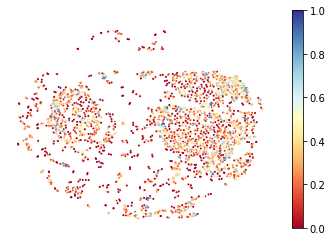

In [47]:
#code the tumogenesis score
import matplotlib.pyplot as plt
img2=plt.scatter(ci_sim_regular['centroid-1'], ci_sim_regular['centroid-0'], 
                 c=(ci_sim_regular['angular_qcd']),s=1,cmap='RdYlBu',
                    vmin=0, vmax=1)
plt.xlim(0,img.shape[0])
plt.ylim(img.shape[1],0)
plt.axis('off')
plt.colorbar(img2)
    